In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv('/Users/miali/Downloads/filtered_tweets_revised_2018_2020.csv')
print(data.head())

         Date       Open       High        Low      Close  Adj Close  \
0  2018-01-02  20.799999  21.474001  20.733334  21.368668  21.368668   
1  2018-01-03  21.400000  21.683332  21.036667  21.150000  21.150000   
2  2018-01-04  20.858000  21.236668  20.378668  20.974667  20.974667   
3  2018-01-05  21.108000  21.149332  20.799999  21.105333  21.105333   
4  2018-01-08  21.066668  22.468000  21.033333  22.427334  22.427334   

      Volume  daily_return  normalized_close        date  \
0   65283000      0.029485         -0.508566  2018-01-02   
1   67822500     -0.010233         -0.510716  2018-01-03   
2  149194500     -0.008290         -0.512440  2018-01-04   
3   68868000      0.006230         -0.511155  2018-01-05   
4  147891000      0.062638         -0.498155  2018-01-08   

   avg_textblob_polarity  avg_vader_sentiment  textblob_polarity_z  \
0               0.452135             0.443897             5.569766   
1               0.374766             0.505215             4.052707

In [33]:
print(len(data))

434


Create lag features

In [3]:
def create_lagged_features(data, cols, lags):
    for col in cols:
        for lag in lags:
            data[f'{col}_lag{lag}'] = data[col].shift(lag)
    return data

In [4]:
lag_columns = ['avg_textblob_polarity', 'avg_vader_sentiment', 'normalized_close']
data = create_lagged_features(data, lag_columns, lags=[2, 3, 4])
data.dropna(inplace=True)  # Drop rows with NaN values due to lagging

In [5]:
print(data[['normalized_close', 'normalized_close_lag2', 'normalized_close_lag3', 'normalized_close_lag4']].corr())

                       normalized_close  normalized_close_lag2  \
normalized_close               1.000000               0.994088   
normalized_close_lag2          0.994088               1.000000   
normalized_close_lag3          0.990725               0.996984   
normalized_close_lag4          0.987313               0.993831   

                       normalized_close_lag3  normalized_close_lag4  
normalized_close                    0.990725               0.987313  
normalized_close_lag2               0.996984               0.993831  
normalized_close_lag3               1.000000               0.996910  
normalized_close_lag4               0.996910               1.000000  


The closed value on previous days is highly correlated with the closed value on the targeted day. Their correlation is 0.99. Using the close value as output might cause overfitting. Therefore, we use returns to reduce dependencies between the data.

Transformation of closed values into the returns

In [6]:
data['return'] = data['normalized_close'].pct_change()
data['return_lag2'] = data['return'].shift(2)
data['return_lag3'] = data['return'].shift(3)
data['return_lag4'] = data['return'].shift(4)
data.dropna(inplace=True)

In [7]:
# Prepare features
data['avg_textblob_polarity_lag2_squared'] = data['avg_textblob_polarity_lag2'] ** 2
data['avg_textblob_polarity_lag2_cubed'] = data['avg_textblob_polarity_lag2'] ** 3
data['avg_vader_sentiment_lag2_squared'] = data['avg_vader_sentiment_lag2'] ** 2
data['avg_vader_sentiment_lag2_cubed'] = data['avg_vader_sentiment_lag2'] ** 3

data['avg_textblob_polarity_lag3_squared'] = data['avg_textblob_polarity_lag3'] ** 2
data['avg_textblob_polarity_lag3_cubed'] = data['avg_textblob_polarity_lag3'] ** 3
data['avg_vader_sentiment_lag3_squared'] = data['avg_vader_sentiment_lag3'] ** 2
data['avg_vader_sentiment_lag3_cubed'] = data['avg_vader_sentiment_lag3'] ** 3

data['avg_textblob_polarity_lag4_squared'] = data['avg_textblob_polarity_lag4'] ** 2
data['avg_textblob_polarity_lag4_cubed'] = data['avg_textblob_polarity_lag4'] ** 3
data['avg_vader_sentiment_lag4_squared'] = data['avg_vader_sentiment_lag4'] ** 2
data['avg_vader_sentiment_lag4_cubed'] = data['avg_vader_sentiment_lag4'] ** 3

data['return_lag2_avg_textblob_interaction'] = data['return_lag2'] * data['avg_textblob_polarity_lag2']
data['return_lag3_avg_textblob_interaction'] = data['return_lag3'] * data['avg_textblob_polarity_lag3']
data['return_lag4_avg_textblob_interaction'] = data['return_lag4'] * data['avg_textblob_polarity_lag4']

data['return_lag2_avg_vader_interaction'] = data['return_lag2'] * data['avg_vader_sentiment_lag2']
data['return_lag3_avg_vader_interaction'] = data['return_lag3'] * data['avg_vader_sentiment_lag3']
data['return_lag4_avg_vader_interaction'] = data['return_lag4'] * data['avg_vader_sentiment_lag4']

Define features combinations

In [8]:
textblob_combinations = [
    ['return_lag2', 'avg_textblob_polarity_lag2'],

    ['return_lag2', 'return_lag3', 'avg_textblob_polarity_lag2', 'avg_textblob_polarity_lag3'],

    ['return_lag2', 'return_lag3', 'return_lag4',
     'avg_textblob_polarity_lag2', 'avg_textblob_polarity_lag3', 'avg_textblob_polarity_lag4'],

    ['return_lag2', 'avg_textblob_polarity_lag2', 'avg_textblob_polarity_lag2_squared'],

    ['return_lag2', 'return_lag3',
     'avg_textblob_polarity_lag2', 'avg_textblob_polarity_lag3', 
     'avg_textblob_polarity_lag2_squared','avg_textblob_polarity_lag3_squared'], 

    ['return_lag2', 'return_lag3', 'return_lag4',
     'avg_textblob_polarity_lag2', 'avg_textblob_polarity_lag3', 'avg_textblob_polarity_lag4',
     'avg_textblob_polarity_lag2_squared', 'avg_textblob_polarity_lag3_squared', 'avg_textblob_polarity_lag4_squared'], 

    ['return_lag2', 'avg_textblob_polarity_lag2', 'avg_textblob_polarity_lag2_squared',
     'avg_textblob_polarity_lag2_cubed'], 

    ['return_lag2', 'return_lag3',
     'avg_textblob_polarity_lag2', 'avg_textblob_polarity_lag3', 
     'avg_textblob_polarity_lag2_squared','avg_textblob_polarity_lag3_squared',
     'avg_textblob_polarity_lag2_cubed', 'avg_textblob_polarity_lag3_cubed'], 

     ['return_lag2', 'return_lag3', 'return_lag4',
     'avg_textblob_polarity_lag2', 'avg_textblob_polarity_lag3', 'avg_textblob_polarity_lag4',
     'avg_textblob_polarity_lag2_squared', 'avg_textblob_polarity_lag3_squared', 'avg_textblob_polarity_lag4_squared',
     'avg_textblob_polarity_lag2_cubed', 'avg_textblob_polarity_lag3_cubed', 'avg_textblob_polarity_lag4_cubed'],

    ['return_lag2', 'avg_textblob_polarity_lag2', 'return_lag2_avg_textblob_interaction'],

    ['return_lag2', 'avg_textblob_polarity_lag2', 'return_lag2_avg_textblob_interaction',
     'return_lag3', 'avg_textblob_polarity_lag3', 'return_lag3_avg_textblob_interaction'],

    ['return_lag2', 'avg_textblob_polarity_lag2', 'return_lag2_avg_textblob_interaction',
     'return_lag3', 'avg_textblob_polarity_lag3', 'return_lag3_avg_textblob_interaction',
     'return_lag4', 'avg_textblob_polarity_lag4', 'return_lag4_avg_textblob_interaction'],

    ['return_lag2', 'return_lag3', 
     'avg_textblob_polarity_lag2', 
     'avg_textblob_polarity_lag2_squared', 
     'return_lag2_avg_textblob_interaction']
]

In [9]:
vader_combinations = [
    ['return_lag2', 'avg_vader_sentiment_lag2'],

    ['return_lag2', 'return_lag3', 
     'avg_vader_sentiment_lag2', 'avg_vader_sentiment_lag3'],

    ['return_lag2', 'return_lag3', 'return_lag4',
     'avg_vader_sentiment_lag2', 'avg_vader_sentiment_lag3', 'avg_vader_sentiment_lag4'],

    ['return_lag2',  'avg_vader_sentiment_lag2', 'avg_vader_sentiment_lag2_squared'],

    ['return_lag2', 'return_lag3',
     'avg_vader_sentiment_lag2', 'avg_vader_sentiment_lag3',
     'avg_vader_sentiment_lag2_squared', 'avg_vader_sentiment_lag3_squared'], 

    ['return_lag2', 'return_lag3', 'return_lag4',
     'avg_vader_sentiment_lag2', 'avg_vader_sentiment_lag3', 'avg_vader_sentiment_lag4', 
     'avg_vader_sentiment_lag2_squared', 'avg_vader_sentiment_lag3_squared', 'avg_vader_sentiment_lag4_squared'],

    ['return_lag2',  'avg_vader_sentiment_lag2', 'avg_vader_sentiment_lag2_squared', 'avg_vader_sentiment_lag2_cubed'],

    ['return_lag2', 'return_lag3',
     'avg_vader_sentiment_lag2', 'avg_vader_sentiment_lag3',
     'avg_vader_sentiment_lag2_squared', 'avg_vader_sentiment_lag3_squared',
     'avg_vader_sentiment_lag2_cubed', 'avg_vader_sentiment_lag3_cubed'], 

    ['return_lag2', 'return_lag3', 'return_lag4',
     'avg_vader_sentiment_lag2', 'avg_vader_sentiment_lag3', 'avg_vader_sentiment_lag4', 
     'avg_vader_sentiment_lag2_squared', 'avg_vader_sentiment_lag3_squared', 'avg_vader_sentiment_lag4_squared',
     'avg_vader_sentiment_lag2_cubed', 'avg_vader_sentiment_lag3_cubed', 'avg_vader_sentiment_lag4_cubed'],
 
    ['return_lag2', 'avg_vader_sentiment_lag2', 'return_lag2_avg_vader_interaction'],

    ['return_lag2', 'avg_vader_sentiment_lag2', 'return_lag2_avg_vader_interaction',
     'return_lag3', 'avg_vader_sentiment_lag3', 'return_lag3_avg_vader_interaction'],

    ['return_lag2', 'avg_vader_sentiment_lag2', 'return_lag2_avg_vader_interaction',
     'return_lag3', 'avg_vader_sentiment_lag3', 'return_lag3_avg_vader_interaction',
     'return_lag4', 'avg_vader_sentiment_lag4', 'return_lag4_avg_vader_interaction'],
]

In [10]:
# Split data into training and test set
train_size = int(len(data) * 0.8)
y = data['return']
y_train, y_test = y[:train_size], y[train_size:]

X_textblob = data[[col for combo in textblob_combinations for col in combo if col in data.columns]]
X_textblob = X_textblob.loc[:, ~X_textblob.columns.duplicated()]

X_vader = data[[col for combo in vader_combinations for col in combo if col in data.columns]]
X_vader = X_vader.loc[:, ~X_vader.columns.duplicated()]

scaler = StandardScaler()
X_textblob = pd.DataFrame(
    scaler.fit_transform(X_textblob),
    columns=X_textblob.columns,
    index=X_textblob.index
)
X_textblob = X_textblob.loc[:, ~X_textblob.columns.duplicated()]

X_vader = pd.DataFrame(
    scaler.fit_transform(X_vader),
    columns=X_vader.columns,
    index=X_vader.index
)
X_vader = X_vader.loc[:, ~X_vader.columns.duplicated()]

Cross-Validation to select the features and sentiment models

In [13]:
def evaluate_combinations(combinations, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    # Data initialization
    best_combo = None
    best_score = np.inf  # Start with a very high MAE for minimization

    linear_model = LinearRegression()

    for combo in combinations:
        if all(col in X.columns for col in combo):  
            scores = cross_val_score(linear_model, X[combo], y, cv=tscv, scoring='neg_mean_absolute_error')
            mean_mae = -np.mean(scores)  # Convert negative MAE to positive for interpretation

            print(f"Features: {combo}")
            print(f"Cross-Validated MAE: {mean_mae}\n")

            if mean_mae < best_score:  # Minimize MAE
                best_score = mean_mae
                best_combo = combo

    return best_combo, best_score


In [16]:
# Evaluate TextBlob combinations
X_train_textblob, X_test_textblob = X_textblob[:train_size], X_textblob[train_size:]
best_textblob_combo, best_textblob_score = evaluate_combinations(textblob_combinations, X_train_textblob, y_train)
print("Best TextBlob Combination:", best_textblob_combo)
print("Best Cross-Validated MAE (TextBlob):", best_textblob_score)

Features: ['return_lag2', 'avg_textblob_polarity_lag2']
Cross-Validated MAE: 0.09308375977338701

Features: ['return_lag2', 'return_lag3', 'avg_textblob_polarity_lag2', 'avg_textblob_polarity_lag3']
Cross-Validated MAE: 0.0926398365512372

Features: ['return_lag2', 'return_lag3', 'return_lag4', 'avg_textblob_polarity_lag2', 'avg_textblob_polarity_lag3', 'avg_textblob_polarity_lag4']
Cross-Validated MAE: 0.09329574266800236

Features: ['return_lag2', 'avg_textblob_polarity_lag2', 'avg_textblob_polarity_lag2_squared']
Cross-Validated MAE: 0.0932439645575945

Features: ['return_lag2', 'return_lag3', 'avg_textblob_polarity_lag2', 'avg_textblob_polarity_lag3', 'avg_textblob_polarity_lag2_squared', 'avg_textblob_polarity_lag3_squared']
Cross-Validated MAE: 0.09301261209891672

Features: ['return_lag2', 'return_lag3', 'return_lag4', 'avg_textblob_polarity_lag2', 'avg_textblob_polarity_lag3', 'avg_textblob_polarity_lag4', 'avg_textblob_polarity_lag2_squared', 'avg_textblob_polarity_lag3_square

In [17]:
# Evaluate VADER combinations
X_train_vader, X_test_vader = X_vader[:train_size], X_vader[train_size:]
best_vader_combo, best_vader_score = evaluate_combinations(vader_combinations, X_train_vader, y_train)
print("Best VADER Combination:", best_vader_combo)
print("Best Cross-Validated MAE (VADER):", best_vader_score)

Features: ['return_lag2', 'avg_vader_sentiment_lag2']
Cross-Validated MAE: 0.0930594867014219

Features: ['return_lag2', 'return_lag3', 'avg_vader_sentiment_lag2', 'avg_vader_sentiment_lag3']
Cross-Validated MAE: 0.09258138594106553

Features: ['return_lag2', 'return_lag3', 'return_lag4', 'avg_vader_sentiment_lag2', 'avg_vader_sentiment_lag3', 'avg_vader_sentiment_lag4']
Cross-Validated MAE: 0.09324212363095707

Features: ['return_lag2', 'avg_vader_sentiment_lag2', 'avg_vader_sentiment_lag2_squared']
Cross-Validated MAE: 0.09302791633024553

Features: ['return_lag2', 'return_lag3', 'avg_vader_sentiment_lag2', 'avg_vader_sentiment_lag3', 'avg_vader_sentiment_lag2_squared', 'avg_vader_sentiment_lag3_squared']
Cross-Validated MAE: 0.09284154611577934

Features: ['return_lag2', 'return_lag3', 'return_lag4', 'avg_vader_sentiment_lag2', 'avg_vader_sentiment_lag3', 'avg_vader_sentiment_lag4', 'avg_vader_sentiment_lag2_squared', 'avg_vader_sentiment_lag3_squared', 'avg_vader_sentiment_lag4_squ

In [18]:
if best_textblob_score > best_vader_score:
    print("TextBlob is the better language model.")
    final_combo = best_textblob_combo
    X_train_final, X_test_final = X_train_textblob, X_test_textblob
else:
    print("Vader is the better language model.")
    final_combo = best_vader_combo
    X_train_final, X_test_final = X_train_vader, X_test_vader

Vader is the better language model.


In [19]:
final_model = LinearRegression()
final_model.fit(X_train_final[final_combo], y_train)
y_pred_test = final_model.predict(X_test_final[final_combo])

In [31]:
print("Intercept:", final_model.intercept_)
print("Coefficients:", dict(zip(final_combo, final_model.coef_)))

Intercept: -0.0210575688860465
Coefficients: {'return_lag2': np.float64(1.9950180775090676), 'avg_vader_sentiment_lag2': np.float64(0.02320145259943196), 'return_lag2_avg_vader_interaction': np.float64(-2.0219978077007505), 'return_lag3': np.float64(-0.8916610260275057), 'avg_vader_sentiment_lag3': np.float64(-0.010375192402581558), 'return_lag3_avg_vader_interaction': np.float64(0.2223934116153116)}


In [29]:
# Evaludations
directional_accuracy = np.mean((y_test * y_pred_test) > 0) * 100

def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    print(f"{model_name} Metrics:")
    print(f"  - Mean Absolute Error (MAE): {mae}")
    print(f"  - Mean Squared Error (MSE): {mse}")
    print(f"  - Directional Accuracy: {directional_accuracy:.2f}%")

evaluate_model(y_test, y_pred_test, "Regression Evaluation (Test Set)")

Regression Evaluation (Test Set) Metrics:
  - Mean Absolute Error (MAE): 0.36157444393548077
  - Mean Squared Error (MSE): 2.358779823926632
  - Directional Accuracy: 50.57%


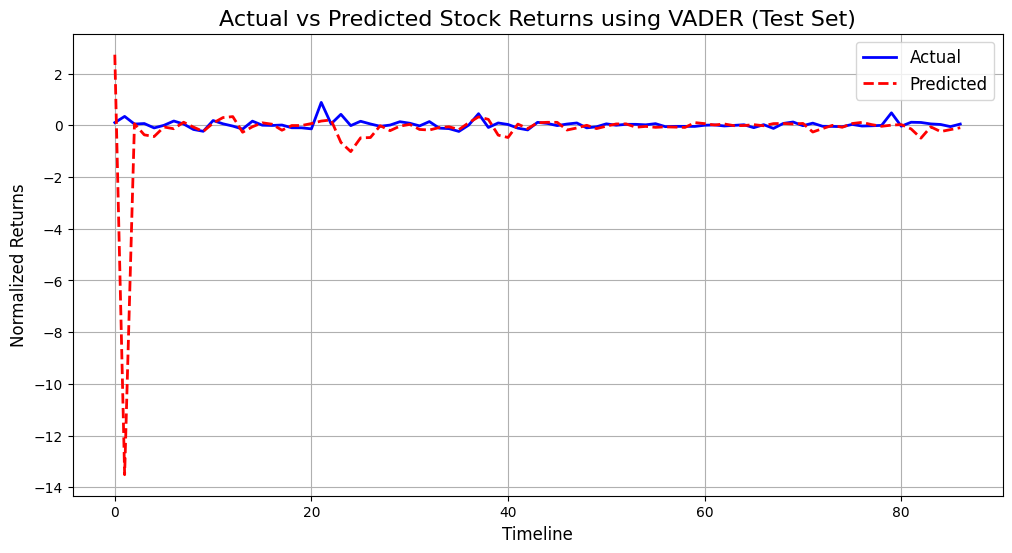

In [27]:
# Visualisations
indices = range(len(y_test))
plt.figure(figsize=(12, 6))
plt.plot(indices, y_test, label="Actual", color="blue", linewidth=2)
plt.plot(indices, y_pred_test, label="Predicted", color="red", linestyle="--", linewidth=2)
plt.title("Actual vs Predicted Stock Returns using VADER (Test Set)", fontsize=16)
plt.xlabel("Timeline", fontsize=12)
plt.ylabel("Normalized Returns", fontsize=12)
plt.legend(fontsize=12)
plt.grid()
plt.show()